# ROSSMAN SALES PREDICTION

# 1. Problem Description

* Id - an Id that represents a (Store, Date) duple within the test set
* Store - a unique Id for each store
* Sales - the turnover for any given day (this is what you are predicting)
* Customers - the number of customers on a given day
* Open - an indicator for whether the store was open: 0 = closed, 1 = open
* StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* StoreType - differentiates between 4 different store models: a, b, c, d
* Assortment - describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance - distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* Promo - indicates whether a store is running a promo on that day
* Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

Ordinal encoder on STORE column is OK for Tree Based Models but not so good for Linear Models.

Show a graph for TimeSeriesKFold showing the folds.

In [42]:
import math
import numpy  as np
import pandas as pd
import random
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
import datetime
import missingno as msno

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML


from sklearn.metrics           import mean_absolute_error, mean_squared_error
from sklearn.ensemble          import RandomForestRegressor
from sklearn.linear_model      import LinearRegression, Lasso
from sklearn.preprocessing     import RobustScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute            import SimpleImputer
from sklearn.pipeline          import Pipeline, make_pipeline 
from sklearn.compose           import ColumnTransformer, TransformedTargetRegressor, make_column_transformer
from sklearn.linear_model      import LinearRegression
from sklearn.base              import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectKBest, SelectPercentile, f_regression, mutual_info_regression, RFECV
from sklearn.svm               import SVR
from sklearn.model_selection   import cross_validate, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_predict

import optuna
from optuna.integration import LightGBMPruningCallback


from lightgbm                  import LGBMRegressor
from sklearn.ensemble          import HistGradientBoostingRegressor

from boruta                    import BorutaPy

import joblib
from shutil import rmtree

from tempfile import mkdtemp


warnings.filterwarnings('ignore')

# 2. Imports and Helper Functions

In [13]:
def mean_absolute_percentage_error(y, y_pred):
    return np.mean(np.abs((y - y_pred)/y))

    
def ml_error(model_name, y, y_pred):
    mae = mean_absolute_error(y, y_pred)
    mape = mean_absolute_percentage_error(y, y_pred)
    rmse = np.sqrt( mean_squared_error(y, y_pred))
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )

def cross_validation(df, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []
    for k in reversed(range(1, kfold +1)):
        if verbose:
            print( '\nKFold Number: {}'.format( k ) )
        # start and end date for validation 
        validation_start_date = df['Date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = df['Date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        train = df[df['Date'] < validation_start_date]
        test = df[(df['Date'] >= validation_start_date) & (df['Date'] <= validation_end_date)]

        # train
        X_train = train.drop(['Customers', 'Sales'], axis=1)
        y_train = train['Sales']

        # validation
        X_test = test.drop(['Customers', 'Sales'], axis=1)
        y_test = test['Sales']

        # model
        m = model.fit(X_train, y_train)

        # prediction
        y_pred = m.predict(X_test)

        # performance
        m_result = ml_error(model_name, y_test, y_pred)

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model Name': model_name,
                          'MAE CV': np.round( np.mean( mae_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mae_list ), 2 ).astype( str ),
                          'MAPE CV': np.round( np.mean( mape_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( mape_list ), 2 ).astype( str ),
                          'RMSE CV': np.round( np.mean( rmse_list ), 2 ).astype( str ) + ' +/- ' + np.round( np.std( rmse_list ), 2 ).astype( str ) }, index=[0] )


def jupyter_settings():
    %matplotlib inline
    
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    sns.set_theme()


def column_names_to_snake_case(df):
    df.columns = [inflection.underscore(c) for c in df.columns]
    return df

def cv_results_to_dataframe(cv_results, model_name):

    scores = ['test_neg_mean_absolute_error', 'test_neg_mean_absolute_percentage_error', 'test_neg_root_mean_squared_error', 'fit_time', 'score_time']

    for score in scores:
        MAE_mean = -np.round(cv_results['test_neg_mean_absolute_error'].mean(), 2)
        MAE_std = np.round(cv_results['test_neg_mean_absolute_error'].std(), 2)

        MAPE_mean = -np.round(cv_results['test_neg_mean_absolute_percentage_error'].mean(), 2)
        MAPE_std = np.round(cv_results['test_neg_mean_absolute_percentage_error'].std(), 2)

        RMSE_mean = -np.round(cv_results['test_neg_root_mean_squared_error'].mean(), 2)
        RMSE_std = np.round(cv_results['test_neg_root_mean_squared_error'].std(), 2)

        mean_fit_time = np.round((cv_results['fit_time'].mean())/60, 2)
        std_fit_time = np.round((cv_results['fit_time'].std())/60, 2)

        score_time = np.round((cv_results['score_time'].mean())/60, 2)
        std_score_time = np.round((cv_results['score_time'].std())/60, 2)

        return pd.DataFrame( {'Model Name': model_name,
                            'MAE CV': MAE_mean.astype( str ) + ' +/- ' + MAE_std .astype( str ),
                            'MAPE CV': MAPE_mean.astype( str ) + ' +/- ' + MAPE_std.astype( str ),
                            'RMSE CV': RMSE_mean.astype( str ) + ' +/- ' + RMSE_std.astype( str ),
                            'Mean Fit Time (min)': mean_fit_time.astype( str ) + ' +/- ' + std_fit_time.astype( str ),
                            'Mean Score Time (min)': score_time.astype( str ) + ' +/- ' + std_score_time.astype( str )}
                            , index=[0])

In [43]:
class TimeSeriesCV:
    """ A cross-validation generator specifically created for time series 
    containing a 'date' column with frequency in days.

    Provides train/test indices to split time series data samples in train/test
    sets. Samples can be observed at irregular time intervals. Multiple samples per
    timestamp are allowed.

    This cross-validation object is a variation of class 'KFold'.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set. Note that unlike standard cross-validation methods,
    successive training sets are supersets of those that come before them.

    It should be used inside a pipeline that drops the 'date' column during 
    preprocessing.

    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.

    test_size : int, default=42
        Used to limit the size of the test set. Default is 42 days, or 6 weeks. 
        
    gap : int, default=0
        Number of DAYS to exclude from the end of each train set before
        the test set.
    """

    def __init__(self, n_splits=5, test_size=42, gap=0):
        self.n_splits = n_splits
        self.test_size = test_size
        self.gap = gap

    def split(self, X, y=None, groups=None):

        n_splits = self.n_splits
        n_folds = n_splits + 1
        test_size = self.test_size
        gap = self.gap

        X.index = np.arange(X.shape[0])

        for k in range(1, n_folds):

            test_start_date = X['date'].max() - datetime.timedelta(days= k * test_size)
            test_end_date = X['date'].max() - datetime.timedelta(days= (k-1) * test_size)

            train_end_date = test_start_date - datetime.timedelta(days=gap)

            train_index = X[X['date'] < train_end_date].index.values
            test_index = X[(X['date'] >= test_start_date) & (X['date'] <= test_end_date)].index.values

            yield train_index, test_index

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

# 3. Data Preparation

## 3.1 Data Import

In [78]:
df_sales_raw = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/store.csv', low_memory=False)

df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

df = df_raw.copy()
df = df[df['Open'] == 1]
df = df[df['Sales'] > 0]
df = df.reset_index(drop=True)
column_names_to_snake_case(df)
df['date'] = pd.to_datetime(df['date'])


X_train = df.drop(['sales', 'customers'], axis=1).copy()
y_train = df['sales'].copy()

print(f'Number of rows: {df.shape[0]}')
print(f'Number of columns: {df.shape[1]}')
df.sample()

Number of rows: 844338
Number of columns: 18


,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
314079,481,6,2014-08-02,5351,516,1,0,0,1,c,c,7470.0,NaN,NaN,1,44.0,2012.0,"Feb,May,Aug,Nov"


In [79]:
df_sales_test = pd.read_csv('/Users/lucasstelmastchuk/Documents/repos/rossman_sales/data/test.csv', low_memory=False)
df_raw_test = pd.merge(df_sales_test, df_store_raw, how='left', on='Store')
column_names_to_snake_case(df_raw_test)
X_test = df_raw_test.drop(['id'], axis=1).copy()
X_test['date'] = pd.to_datetime(X_test['date'])
X_test.head()

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,3,4,2015-09-17,1.0,1,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
2,7,4,2015-09-17,1.0,1,0,0,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
3,8,4,2015-09-17,1.0,1,0,0,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
4,9,4,2015-09-17,1.0,1,0,0,a,c,2030.0,8.0,2000.0,0,NaN,NaN,NaN


## 3.2 Data Cleaning

<AxesSubplot:>

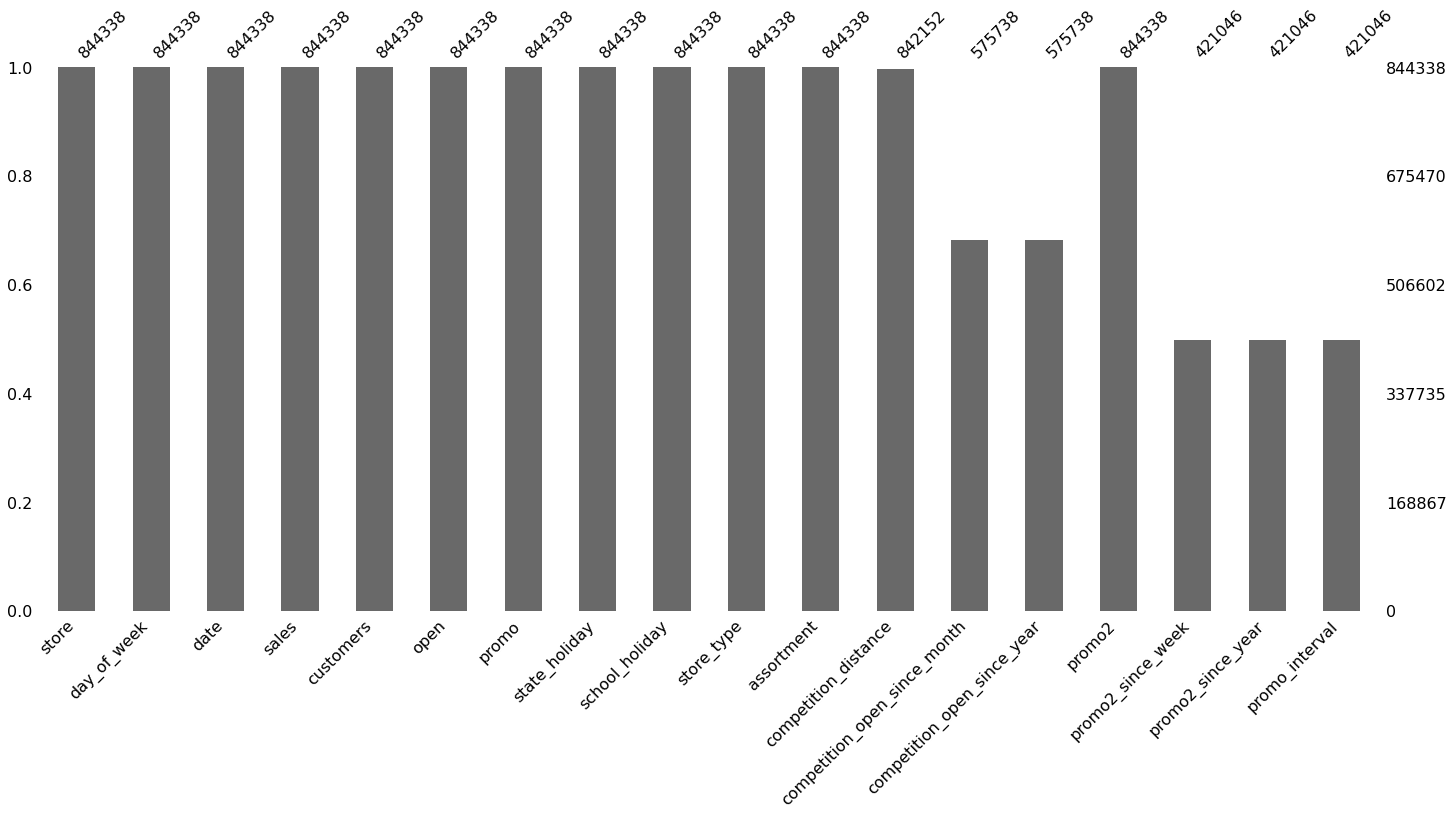

In [7]:
msno.bar(df)

<AxesSubplot:>

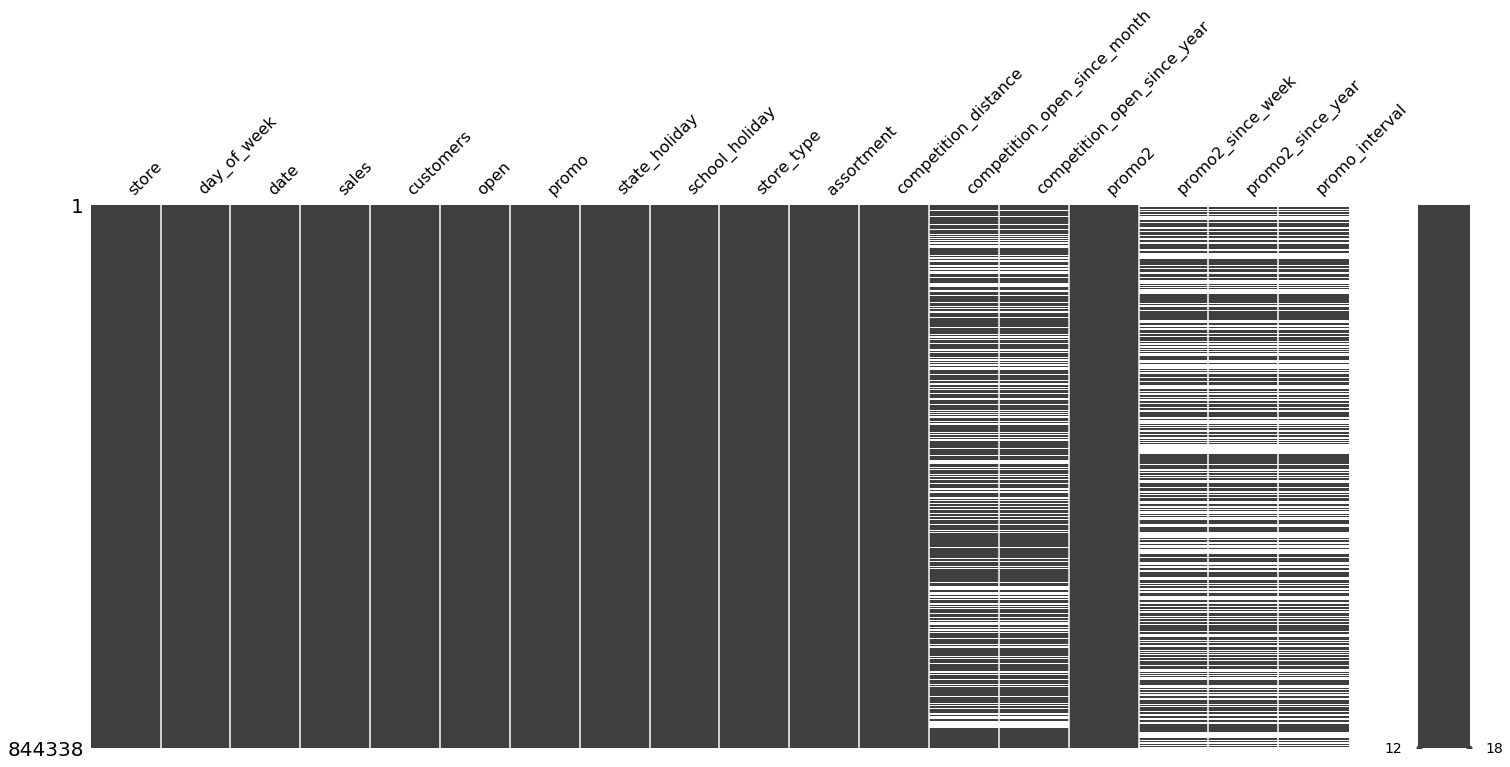

In [8]:
msno.matrix(df)

<AxesSubplot:>

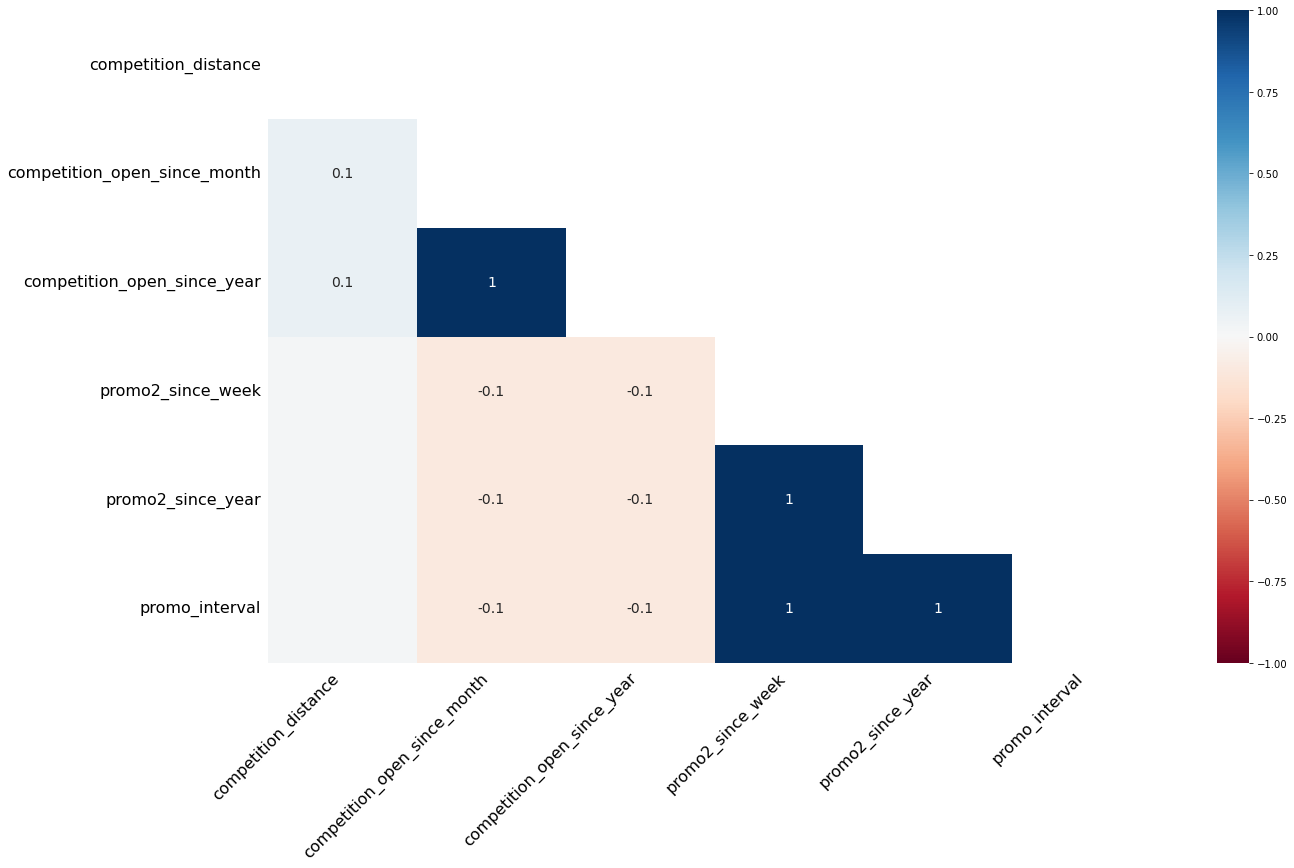

In [9]:
msno.heatmap(df)

In [6]:
class MissingValueImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        
        self.competition_open_since_month_imputer = SimpleImputer(strategy='median').fit(X[['competition_open_since_month']])
        self.competition_open_since_year_imputer = SimpleImputer(strategy='median').fit(X[['competition_open_since_year']])
        
        return self
    
    def transform(self, X):
        
        X = X.copy()

        # FILLING IN MISSING VALUES
        # Maximum competition distance is 75,860 meters. Considering that missing values are probably related to stores with
        # no competition nearby, these stores will get the value 200,000 meters to indicate that competitors are far away.      
        X['competition_distance'] = X['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        # Imputation of the median competition opening month and year for stores with no information about competition opening date.
        # Note that missing values here do not represent absence of competition, but absence of information about competition opening date,
        # as competion distance have very few missing values.
        X['competition_open_since_month'] = self.competition_open_since_month_imputer.transform(X[['competition_open_since_month']])
        X['competition_open_since_year'] = self.competition_open_since_year_imputer.transform(X[['competition_open_since_year']])

        # Missing values for start of promo2 are linked to stores that do not participate in this second type of promotion at any given year.
        # Missing values will be replaced with the current date so that the total elapsed time for these stores since the start of the 
        # promotion 2 will always be zero 0 (see feature engineering section).
        X['promo2_since_week'] = X.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
        X['promo2_since_year'] = X.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        # CORRECTING DATA TYPES
        X['competition_open_since_month'] = X['competition_open_since_month'].astype(int)
        X['competition_open_since_year'] = X['competition_open_since_year'].astype(int)
        X['promo2_since_week'] = X['promo2_since_week'].astype(int)
        X['promo2_since_year'] = X['promo2_since_year'].astype(int)
        
        return X

# 4. Feature Engineering

In [7]:
class AttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self,  cyclical_features=True):
        self.cyclical_features = cyclical_features
    
    def fit(self, X, y=None):
        return self
    
    def _transform_promo_interval(self, x):
            if x['promo_interval'] == 'Jan,Apr,Jul,Oct':
                if x['date'].month in [1, 4, 7, 10]:
                    return 1
                elif x['date'].month in [2, 5, 8, 11]:
                    return 2
                elif x['date'].month in [3, 6, 9, 12]:
                    return 3
            elif x['promo_interval'] == 'Feb,May,Aug,Nov':
                if x['date'].month in [2, 5, 8, 11]:
                    return 1
                elif x['date'].month in [3, 6, 9, 12]:
                    return 2
                elif x['date'].month in [1, 4, 7, 10]:
                    return 3
            elif x['promo_interval'] == 'Mar,Jun,Sept,Dec':
                if x['date'].month in [3, 6, 9, 12]:
                    return 1
                elif x['date'].month in [1, 4, 7, 10]:
                    return 2
                elif x['date'].month in [2, 5, 8, 11]:
                    return 3
            else:
                return 0

    def _sin_transform(self, col, period):
                return np.sin(2*np.pi*col/period)
            
    def _cos_transform(self, col, period):
                return np.cos(2*np.pi*col/period)

    def transform(self, X):
        
        X = X.copy()

        # Extract features from date column
        X['month'] = X['date'].dt.month
        X['day_of_month'] = X['date'].dt.day
        X['week_of_year'] = X['date'].dt.isocalendar().week
        X['is_weekend'] = X['date'].dt.weekday > 4
        X['is_weekend'] = X['is_weekend'].astype(int)
        
        # Correct data types
        X['competition_open_since_month'] = X['competition_open_since_month'].astype(int)
        X['competition_open_since_year'] = X['competition_open_since_year'].astype(int)
        X['promo2_since_week'] = X['promo2_since_week'].astype(int)
        X['promo2_since_year'] = X['promo2_since_year'].astype(int)

        # Combine year and month of competition opening and then calculate the elapsed time in months since competition opened.
        X['competition_since_date'] = X.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],
                                                                            month=x['competition_open_since_month'],
                                                                            day=1), axis=1)
        X['months_since_competition_opened'] = ((X['date'] - X['competition_since_date'])/pd.Timedelta('30 days')).astype(int)
        X['months_since_competition_opened'] = X['months_since_competition_opened'].apply(lambda x: 0 if x < 0 else x)

        # promo since
        X['promo2_since_date'] = X['promo2_since_year'].astype(str) + '-' + X['promo2_since_week'].astype(str)
        X['promo2_since_date'] = X['promo2_since_date'].apply(lambda x: datetime.datetime.strptime(x + '-0', '%Y-%W-%w'))
        X['weeks_since_promo2_started'] = ((X['date'] - X['promo2_since_date'])/pd.Timedelta('7 days')).astype(int)
        X['weeks_since_promo2_started'] = X['weeks_since_promo2_started'].apply(lambda x: 0 if x < 0 else x)

        # promo interval
        X['promo_interval'] = X[['date', 'promo_interval']].apply(lambda y: self._transform_promo_interval(y), axis=1)

        # Drop unnecessary columns
        X.drop(['date','open', 'competition_open_since_month', 'competition_open_since_year', 
                'promo2_since_week', 'promo2_since_year', 'competition_since_date', 'promo2_since_date'], 
                axis=1, inplace=True)

        # Add cyclical features
        if self.cyclical_features:
            
            X['sin_month'] = self._sin_transform(X['month'], 12)
            X['cos_month'] = self._cos_transform(X['month'], 12)
            
            X['sin_day_of_month'] = self._sin_transform(X['day_of_month'], 30)
            X['cos_day_of_month'] = self._cos_transform(X['day_of_month'], 30)

            X['sin_day_of_week'] = self._sin_transform(X['day_of_week'], 7)
            X['cos_day_of_week'] = self._cos_transform(X['day_of_week'], 7)


            X['sin_week_of_year'] = self._sin_transform(X['month'], 52)
            X['cos_week_of_year'] = self._cos_transform(X['month'], 52)
  
            X.drop(['month', 'day_of_month', 'day_of_week', 'week_of_year'], axis=1, inplace=True)
            
        return X

In [8]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.competition_distance_scaler = RobustScaler().fit(X[['competition_distance']])
        self.months_since_competition_opened_scaler = RobustScaler().fit(X[['months_since_competition_opened']])
        self.weeks_since_promo2_started_scaler = RobustScaler().fit(X[['weeks_since_promo2_started']])
        return self
    
    def transform(self, X):
        
        X = X.copy()

        # SCALING NUMERICAL FEATURES
        X['competition_distance'] = self.competition_distance_scaler.transform(X[['competition_distance']]).ravel()
        X['months_since_competition_opened'] = self.months_since_competition_opened_scaler.transform(X[['months_since_competition_opened']]).ravel()
        X['weeks_since_promo2_started'] = self.weeks_since_promo2_started_scaler.transform(X[['weeks_since_promo2_started']]).ravel()

        return X

In [9]:
class Encoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        
        self.state_holiday_encoder = OneHotEncoder(handle_unknown='ignore').fit(X[['state_holiday']])
        self.state_holiday_new_columns = self.state_holiday_encoder.get_feature_names_out()

        self.store_type_encoder = OneHotEncoder(handle_unknown='ignore').fit(X[['store_type']])
        self.store_type_new_columns = self.store_type_encoder.get_feature_names_out()

        return self
    
    def transform(self, X):
        
        X = X.copy()

        # ENCODING CATEGORICAL FEATURES
        X['assortment'] = X['assortment'].map({'a': 1, 'b': 2, 'c': 3})
        X['state_holiday'] = X['state_holiday'].map({'a': 'public_holiday', 'b': 'easter', 'c': 'christmas', '0': 'not_holiday'})

        state_holiday_encoded = pd.DataFrame(self.state_holiday_encoder.transform(X[['state_holiday']]).toarray(), columns=self.state_holiday_new_columns, index=X.index)

        store_type_encoded = pd.DataFrame(self.store_type_encoder.transform(X[['store_type']]).toarray(), columns=self.store_type_new_columns, index=X.index)

        X = pd.concat([X, state_holiday_encoded, store_type_encoded], axis=1).drop(['store_type', 'state_holiday'], axis=1)

        return X

## FEATURE SELECTION

In [10]:
pipeline = Pipeline(steps=[('data_frame_cleaner', MissingValueImputer()),
                             ('attributes_adder', AttributesAdder()),
                             ('scaler', Scaler()),
                             ('encoder', Encoder()),
                             ('feature_selection', SelectPercentile(mutual_info_regression, percentile=65)),
                             ])

In [76]:
df_selected = pipeline.fit_transform(X_train, y_train)
df_selected = pd.DataFrame(df_selected, columns=pipeline[-1].get_feature_names_out())
df_selected.head()

,store,promo,assortment,competition_distance,promo2,promo_interval,is_weekend,months_since_competition_opened,weeks_since_promo2_started,cos_month,sin_day_of_month,cos_day_of_month,sin_day_of_week,cos_day_of_week,sin_week_of_year,cos_week_of_year,store_type_b
0,1.0,1.0,1.0,-0.170968,0.0,0.0,0.0,0.844444,0.000000,-0.866025,0.207912,0.978148,-0.974928,-0.222521,0.748511,0.663123,0.0
1,2.0,1.0,1.0,-0.283871,1.0,1.0,0.0,1.066667,2.588785,-0.866025,0.207912,0.978148,-0.974928,-0.222521,0.748511,0.663123,0.0
2,3.0,1.0,1.0,1.903226,1.0,1.0,0.0,1.311111,2.093458,-0.866025,0.207912,0.978148,-0.974928,-0.222521,0.748511,0.663123,0.0
3,4.0,1.0,3.0,-0.275806,0.0,0.0,0.0,0.555556,0.000000,-0.866025,0.207912,0.978148,-0.974928,-0.222521,0.748511,0.663123,0.0
4,5.0,1.0,1.0,4.448387,0.0,0.0,0.0,-0.933333,0.000000,-0.866025,0.207912,0.978148,-0.974928,-0.222521,0.748511,0.663123,0.0


In [77]:
df_selected.shape

(844338, 17)

# 7. Machine Learning Models

### Linear Regression

In [112]:
linear_regression_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                                             ('attributes_adder', AttributesAdder()),
                                             ('scaler', Scaler()),
                                             ('encoder', Encoder()),
                                             ('feature_selection', SelectPercentile(mutual_info_regression, percentile=65)),
                                             ('model', TransformedTargetRegressor(LinearRegression(), func=np.log1p, inverse_func=np.expm1))
                                             ])
linear_regression_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('feature_selection',
                 SelectPercentile(percentile=65,
                                  score_func=<function mutual_info_regression at 0x7f9f12cc85e0>)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LinearRegression()))])

In [113]:
linear_regression_cv_results = cross_validate(linear_regression_pipeline, X_train, y_train,
                                              scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                                              cv=TimeSeriesCV(n_splits=5, gap=14),
                                              error_score='raise',
                                              n_jobs=-1
                                              )

linear_regression_cv_df = cv_results_to_dataframe(linear_regression_cv_results, 'Linear Regression')

linear_regression_cv_df

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1912.14 +/- 120.01,0.29 +/- 0.0,2724.7 +/- 199.37


### Lasso

In [75]:
lasso_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                                 ('attributes_adder', AttributesAdder()),
                                 ('scaler', Scaler()),
                                 ('encoder', Encoder()),
                                #  ('feature_selection', SelectPercentile(mutual_info_regression, percentile=65)),
                                 ('model', TransformedTargetRegressor(Lasso(alpha=0.01), func=np.log1p, inverse_func=np.expm1))
                                ])
lasso_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=Lasso(alpha=0.01)))])

In [80]:
lasso_cv_results = cross_validate(lasso_pipeline, X_train, y_train,
                                  scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                                  cv=TimeSeriesCV(n_splits=5, gap=14),
                                  error_score='raise',
                                  n_jobs=-1
                                  )

lasso_cv_df = cv_results_to_dataframe(lasso_cv_results, 'Lasso')

lasso_cv_df

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,Lasso,1948.87 +/- 132.01,0.29 +/- 0.01,2811.78 +/- 219.46,0.85 +/- 0.07,0.04 +/- 0.01


### Random Forest

In [15]:
rf_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                              ('attributes_adder', AttributesAdder()),
                              ('scaler', Scaler()),
                              ('encoder', Encoder()),
                              ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                              ('model', TransformedTargetRegressor(RandomForestRegressor(n_estimators=250, n_jobs=-1, random_state=1), func=np.log1p, inverse_func=np.expm1))
                              ])
rf_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('feature_selection',
                 SelectPercentile(percentile=100,
                                  score_func=<function mutual_info_regression at 0x7ff7927291f0>)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=RandomForestRegressor(n_estimators=250,
                                                                            n_jobs=-1,
                                                                            random_state=1)))])

In [16]:
rf_cv_results = cross_validate(rf_pipeline, X_train, y_train,
                               scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                               cv=TimeSeriesCV(n_splits=5, gap=14),
                               error_score='raise',
                               n_jobs=-1
                               )

random_forest_cv_df = cv_results_to_dataframe(rf_cv_results, 'Random Forest')

random_forest_cv_df

### XGB

In [39]:
xgb_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                               ('attributes_adder', AttributesAdder()),
                               ('scaler', Scaler()),
                               ('encoder', Encoder()),
                               ('feature_selection', SelectPercentile(mutual_info_regression, percentile=65)),
                               ('model', TransformedTargetRegressor(xgb.XGBRegressor(objective='reg:squarederror',
                                                                                      n_estimators=2000,
                                                                                      max_depth=10, 
                                                                                      subsample=0.7,
                                                                                      colsample_bytree=0.9,
                                                                                      min_child_weight = 3),
                                                                    func=np.log1p, inverse_func=np.expm1))
                                ])
xgb_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('feature_selection',
                 SelectPercentile(percentile=65,
                                  score_func=<function mutual_info_regression at 0x7fba41152670>)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regress...
                                                                   interaction_constraints=None,
                                                                   learning_rate=None,
                                                                   max_delta_step=None,
                                                                   max_depth=10,
                                                                   min_child_weight=3,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   n_estimators=2000,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None,
                                                                   predictor=None,
                                                                   random_state=None,
                                                                   reg_alpha=None,
                                                                   reg_lambda=None,
                                                                   scale_pos_weight=None,
                                                                   subsample=0.7,
                                                                   tree_method=None,
                                                                   validate_parameters=None,
                                                                   verbosity=None)))])

In [40]:
xgb_cv_results = cross_validate(xgb_pipeline, X_train, y_train,
                                scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                                cv=TimeSeriesCV(n_splits=5, gap=14),
                                error_score='raise',
                                n_jobs=-1
                                )

xgb_cv_df = cv_results_to_dataframe(xgb_cv_results, 'XGB')

xgb_cv_df

/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lucas1/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lucas1/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lucas1/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lu

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,XGB,908.26 +/- 121.49,0.13 +/- 0.01,1301.43 +/- 176.52,632.74 +/- 1.03,0.09 +/- 0.03


### Histogram Gradient Boosting

In [274]:
hgb_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                              ('attributes_adder', AttributesAdder()),
                              ('scaler', Scaler()),
                              ('encoder', Encoder()),
                              ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                              ('model', TransformedTargetRegressor(HistGradientBoostingRegressor(max_iter=3000, max_leaf_nodes=80), func=np.log1p, inverse_func=np.expm1))
                              ])
hgb_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('feature_selection',
                 SelectPercentile(percentile=100,
                                  score_func=<function mutual_info_regression at 0x7f9f12cc85e0>)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=HistGradientBoostingRegressor(max_iter=3000,
                                                                                    max_leaf_nodes=80)))])

In [275]:
hgb_cv_results = cross_validate(hgb_pipeline, X_train, y_train,
                               scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                               cv=TimeSeriesCV(n_splits=5, gap=14),
                               error_score='raise',
                               n_jobs=-1
                               )

hgb_cv_df = cv_results_to_dataframe(hgb_cv_results, 'Hist Gradient Boosting')

hgb_cv_df

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Hist Gradient Boosting,803.52 +/- 112.17,0.11 +/- 0.01,1167.57 +/- 149.15


### LightGBM

In [37]:
lgbm_pipeline = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                               ('attributes_adder', AttributesAdder()),
                               ('scaler', Scaler()),
                               ('encoder', Encoder()),
                               ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                               ('model', TransformedTargetRegressor(LGBMRegressor(num_leaves=500,
                                                                                  learning_rate=0.01,
                                                                                  n_estimators=3500),
                                                                    func=np.log1p, inverse_func=np.expm1))
                                ])

lgbm_pipeline

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('feature_selection',
                 SelectPercentile(percentile=100,
                                  score_func=<function mutual_info_regression at 0x7fba41152670>)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LGBMRegressor(learning_rate=0.01,
                                                                    n_estimators=3500,
                                                                    num_leaves=500)))])

In [38]:
lgbm_cv_results = cross_validate(lgbm_pipeline, X_train, y_train,
                                scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
                                cv=TimeSeriesCV(n_splits=5, gap=14),
                                error_score='raise',
                                n_jobs=-1
                                )

lgbm_cv_df = cv_results_to_dataframe(lgbm_cv_results, 'LightGBM')

lgbm_cv_df

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min),Mean Score Time (min)
0,LightGBM,806.39 +/- 105.45,0.11 +/- 0.01,1172.94 +/- 145.09,9.26 +/- 0.67,1.7 +/- 0.24


### Model Performance Comparison

In [276]:
models_cv = pd.concat([linear_regression_cv_df, lasso_cv_df, random_forest_cv_df, xgb_cv_df, hgb_cv_df, lgbm_cv_df]).reset_index(drop=True)
models_cv = pd.concat([models_cv, fit_times], axis=1)
models_cv

,Model Name,MAE CV,MAPE CV,RMSE CV,Mean Fit Time (min)
0,Linear Regression,1912.14 +/- 120.01,0.29 +/- 0.0,2724.7 +/- 199.37,5.78
1,Lasso,1948.87 +/- 132.01,0.29 +/- 0.01,2811.78 +/- 219.46,1.04
2,Random Forest,834.49 +/- 127.6,0.12 +/- 0.01,1252.34 +/- 189.65,12.83
3,XGB,891.36 +/- 117.41,0.13 +/- 0.01,1272.48 +/- 170.1,137.27
4,Hist Gradient Boosting,803.52 +/- 112.17,0.11 +/- 0.01,1167.57 +/- 149.15,27.79
5,LightGBM,806.39 +/- 105.45,0.11 +/- 0.01,1172.94 +/- 145.09,21.20


### Hyperparameter Fine Tuning

In [183]:
# lgbm_pipeline_params = {
#  'attributes_adder__cyclical_features': [True, False],
#  'feature_selection__percentile': [50, 65, 100],
#  'model__regressor__boosting_type': ['gbdt', 'dart'],
#  'model__regressor__colsample_bytree': [0.3, 0.7, 0.9],
#  'model__regressor__learning_rate': [0.01, 0.05, 0.1, 0.3],
#  'model__regressor__min_child_samples': [10, 20, 30],
#  'model__regressor__min_child_weight': [3, 8, 15],
#  'model__regressor__n_estimators': [1500, 1700, 2500, 3000, 3500],
#  'model__regressor__num_leaves': [20, 50, 75, 100, 150, 200],
#  'model__regressor__subsample': [0.1, 0.5, 0.7],
#  'model__regressor__subsample_for_bin': [200000, 1000000, 2000000],
# }

In [245]:
lgbm_pipeline_params = {
 'model__regressor__learning_rate': [0.01, 0.1, 0.3],
 'model__regressor__n_estimators': [1500, 2000, 2500],
 'model__regressor__num_leaves': [20, 50, 75, 100],
}

In [221]:
random_search = RandomizedSearchCV(
    estimator=lgbm_pipeline_tuning,
    param_distributions=lgbm_pipeline_params,
    n_iter=1,
    n_jobs=-1,
    cv=TimeSeriesCV(n_splits=5, gap=14),
    scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
    refit='neg_root_mean_squared_error',
    error_score='raise', 
    verbose=5)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 4/5] END attributes_adder__cyclical_features=False, feature_selection__percentile=65, model__regressor__learning_rate=0.1, model__regressor__n_estimators=2500, model__regressor__num_leaves=100; neg_mean_absolute_error: (test=-669.905) neg_mean_absolute_percentage_error: (test=-0.102) neg_root_mean_squared_error: (test=-983.809) total time= 5.6min
[CV 5/5] END attributes_adder__cyclical_features=False, feature_selection__percentile=65, model__regressor__learning_rate=0.1, model__regressor__n_estimators=2500, model__regressor__num_leaves=100; neg_mean_absolute_error: (test=-809.398) neg_mean_absolute_percentage_error: (test=-0.122) neg_root_mean_squared_error: (test=-1170.134) total time= 6.0min
[CV 3/5] END attributes_adder__cyclical_features=False, feature_selection__percentile=65, model__regressor__learning_rate=0.1, model__regressor__n_estimators=2500, model__regressor__num_leaves=100; neg_mean_absolute_error: (test=-989.

RandomizedSearchCV(cv=<__main__.TimeSeriesKFold object at 0x7f9f161cb280>,
                   error_score='raise',
                   estimator=Pipeline(steps=[('missing_value_imputer',
                                              MissingValueImputer()),
                                             ('attributes_adder',
                                              AttributesAdder()),
                                             ('scaler', Scaler()),
                                             ('encoder', Encoder()),
                                             ('feature_selection',
                                              SelectPercentile(percentile=65,
                                                               score_func=<function mutual_info_regression at 0x7f9f12...
                   param_distributions={'attributes_adder__cyclical_features': [True,
                                                                                False],
                                        'feature_selection__percentile': [50,
                                                                          65,
                                                                          100],
                                        'model__regressor__learning_rate': [0.01,
                                                                            0.1,
                                                                            0.3],
                                        'model__regressor__n_estimators': [1500,
                                                                           2000,
                                                                           2500],
                                        'model__regressor__num_leaves': [20, 50,
                                                                         75,
                                                                         100]},
                   refit='neg_root_mean_squared_error',
                   scoring=['neg_mean_absolute_error',
                            'neg_mean_absolute_percentage_error',
                            'neg_root_mean_squared_error'],
                   verbose=5)

In [248]:
grid_search = GridSearchCV(
    estimator=lgbm_pipeline_tuning,
    param_grid=lgbm_pipeline_params,
    n_jobs=-1,
    cv=TimeSeriesCV(n_splits=5, gap=14),
    scoring=['neg_mean_absolute_error', 'neg_mean_absolute_percentage_error','neg_root_mean_squared_error'],
    refit='neg_root_mean_squared_error',
    error_score='raise', 
    verbose=5)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


PicklingError: ("Can't pickle <class '__main__.MissingValueImputer'>: it's not found as __main__.MissingValueImputer", 'PicklingError while hashing {\'transformer\': MissingValueImputer(), \'X\':         store  day_of_week  ... promo2_since_year   promo_interval\n54835       2            4  ...            2010.0  Jan,Apr,Jul,Oct\n54836       4            4  ...               NaN              NaN\n54837       5            4  ...               NaN              NaN\n54838       6            4  ...               NaN              NaN\n54839       7            4  ...               NaN              NaN\n...       ...          ...  ...               ...              ...\n844333    682            2  ...               NaN              NaN\n844334    733            2  ...               NaN              NaN\n844335    769            2  ...            2012.0  Jan,Apr,Jul,Oct\n844336    948            2  ...               NaN              NaN\n844337   1097            2  ...               NaN              NaN\n\n[789503 rows x 16 columns], \'y\': 63556       5810\n63558      10200\n63559       5807\n63560       5749\n63561       9696\n           ...  \n1016776     3375\n1016827    10765\n1016863     5035\n1017042     4491\n1017190     5961\nName: sales, Length: 789503, dtype: int64, \'weight\': None, \'message_clsname\': \'Pipeline\', \'message\': None, \'**\': {}}: PicklingError("Can\'t pickle <class \'__main__.MissingValueImputer\'>: it\'s not found as __main__.MissingValueImputer")')

## Optuna Bayesian Hyperparameter Tuning

In [251]:
lgbm_pipeline_tuning = Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                               ('attributes_adder', AttributesAdder()),
                               ('scaler', Scaler()),
                               ('encoder', Encoder()),
                               ('feature_selection', SelectPercentile(mutual_info_regression, percentile=100)),
                               ('model', TransformedTargetRegressor(LGBMRegressor(), func=np.log1p, inverse_func=np.expm1))
                                ])

lgbm_pipeline_tuning

Pipeline(steps=[('missing_value_imputer', MissingValueImputer()),
                ('attributes_adder', AttributesAdder()), ('scaler', Scaler()),
                ('encoder', Encoder()),
                ('feature_selection',
                 SelectPercentile(percentile=100,
                                  score_func=<function mutual_info_regression at 0x7fba41152670>)),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LGBMRegressor()))])

In [248]:
def objective(trial, X, y):
    param_grid = {
        'attributes_adder__cyclical_features': trial.suggest_categorical('attributes_adder__cyclical_features', [True, False]),
        'feature_selection__percentile': trial.suggest_int("feature_selection_percentile", 60, 100, step=10),
        'model__regressor__n_estimators': trial.suggest_categorical("n_estimators", [10000]),
        'model__regressor__learning_rate': trial.suggest_float("learning_rate", 0.01, 0.3),
        'model__regressor__num_leaves': trial.suggest_int("num_leaves", 20, 3000, step=20),
        "model__regressor__max_depth": trial.suggest_int("max_depth", 3, 12),
        "model__regressor__min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
        "model__regressor__lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
        "model__regressor__lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
        "model__regressor__min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "model__regressor__bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.95, step=0.1),
        "model__regressor__bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "model__regressor__feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.95, step=0.1),
        "model__regressor__eval_metric": 'l2',
        "model__regressor__early_stopping_rounds": 100,
        "model__regressor__callbacks": [LightGBMPruningCallback(trial, "l2")]
    }

    lgbm_pipeline_tuning.set_params(**param_grid)
    X_transformed = lgbm_pipeline_tuning[:-1].fit_transform(X, y)

    cv = TimeSeriesCV(n_splits=5, gap=14)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X)):
        X_training, X_testing = X_transformed[train_idx], X_transformed[test_idx]
        y_training, y_testing = y.iloc[train_idx].values, y.iloc[test_idx].values

        param_grid['model__regressor__eval_set'] = [zip(X_testing, y_testing.reshape(-1, 1))]
        
        lgbm_pipeline_tuning.set_params(**param_grid)
        
        lgbm_pipeline_tuning[-1].fit(X_training, y_training)
        predictions = lgbm_pipeline_tuning[-1].predict(X_testing)
        cv_scores[idx] = mean_squared_error(y_testing, predictions)**0.5

    return np.mean(cv_scores)

In [249]:
study = optuna.create_study(direction="minimize", study_name='LGBM Regressor')
func = lambda trial: objective(trial, X_train, y_train)
study.optimize(func, n_trials=1)

[I 2022-08-23 15:17:41,607] A new study created in memory with name: LGBM Regressor
[W 2022-08-23 15:21:15,425] Trial 0 failed because of the following error: ValueError('For early stopping, at least one dataset and eval metric is required for evaluation')
Traceback (most recent call last):
  File "/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lucas1/lib/python3.9/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/x7/b7jchjl54wsgp7ngc6r0wmpm0000gn/T/ipykernel_1399/2830084876.py", line 2, in <lambda>
    func = lambda trial: objective(trial, X_train, y_train)
  File "/var/folders/x7/b7jchjl54wsgp7ngc6r0wmpm0000gn/T/ipykernel_1399/4154131361.py", line 35, in objective
    lgbm_pipeline_tuning[-1].fit(X_training, y_training)
  File "/Users/lucasstelmastchuk/opt/anaconda3/envs/ds_em_producao_lucas1/lib/python3.9/site-packages/sklearn/compose/_target.py", line 252, in fit
    self.regressor_.fit(X, y_trans, *

ValueError: For early stopping, at least one dataset and eval metric is required for evaluation

In [253]:
X_transformed = lgbm_pipeline_tuning[:-1].fit_transform(X_train, y_train)
X_transformed.shape

In [ ]:
for i in zip(X_transformed.tolist(), y_train.values):
    print(i)

In [271]:
y_train.values

array([5263, 6064, 8314, ..., 5035, 4491, 5961])

In [262]:
y_train.values.reshape(-1, 1)

array([[5263],
       [6064],
       [8314],
       ...,
       [5035],
       [4491],
       [5961]])

In [191]:
study.optimize(func, n_trials=1)

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=9600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=9600
[LightGBM] [Warning] lambda_l2 is set=50, reg_lambda=0.0 will be ignored. Current value: lambda_l2=50
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.6000000000000001, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6000000000000001
[LightGBM] [Warning] min_gain_to_split is set=12.129160922873446, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=12.129160922873446
[LightGBM] [Warning] lambda_l1 is set=90, reg_alpha=0.0 will be ignored. Current value: lambda_l1=90
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_

[I 2022-08-23 14:40:08,757] Trial 1 finished with value: 2513.4842800307315 and parameters: {'attributes_adder__cyclical_features': True, 'feature_selection_percentile': 80, 'n_estimators': 10000, 'learning_rate': 0.23670822676534733, 'num_leaves': 2880, 'max_depth': 12, 'min_data_in_leaf': 9600, 'lambda_l1': 90, 'lambda_l2': 50, 'min_gain_to_split': 12.129160922873446, 'bagging_fraction': 0.6000000000000001, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 0 with value: 2443.660308486959.


In [189]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

	Best value (rmse): 2443.66031
	Best params:
		attributes_adder__cyclical_features: True
		feature_selection_percentile: 60
		n_estimators: 10000
		learning_rate: 0.23694489069258837
		num_leaves: 840
		max_depth: 7
		min_data_in_leaf: 6000
		lambda_l1: 45
		lambda_l2: 75
		min_gain_to_split: 2.8328452517674445
		bagging_fraction: 0.4
		bagging_freq: 1
		feature_fraction: 0.4


<AxesSubplot:title={'center':'Optimization History Plot'}, xlabel='#Trials', ylabel='Objective Value'>

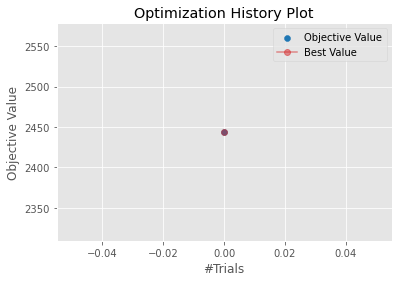

In [190]:
from optuna.visualization.matplotlib import plot_optimization_history
plot_optimization_history(study)

In [203]:
(a, y_train.values)

(array([[1.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
         0.000e+00],
        [2.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        [3.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
         0.000e+00],
        ...,
        [7.690e+02, 0.000e+00, 1.000e+00, ..., 1.000e+00, 0.000e+00,
         0.000e+00],
        [9.480e+02, 0.000e+00, 1.000e+00, ..., 1.000e+00, 0.000e+00,
         0.000e+00],
        [1.097e+03, 0.000e+00, 1.000e+00, ..., 1.000e+00, 0.000e+00,
         0.000e+00]]),
 array([5263, 6064, 8314, ..., 5035, 4491, 5961]))

In [213]:
b = y_train.values.reshape(-1, 1)

In [214]:
arr = np.append(a, b, axis=1)

In [216]:
arr.shape

(844338, 27)

In [218]:
arr.shape

(844338, 27)

In [221]:
a

array([[1.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [2.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [3.000e+00, 1.000e+00, 1.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       ...,
       [7.690e+02, 0.000e+00, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [9.480e+02, 0.000e+00, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00],
       [1.097e+03, 0.000e+00, 1.000e+00, ..., 1.000e+00, 0.000e+00,
        0.000e+00]])

In [239]:
for i in zip(a, y_train.values.reshape(-1, 1)):
    print(i)

(array([8234]), array([5263]))
(array([6064]), array([6064]))


In [243]:
y_train.values.reshape(-1, 1)

(844338, 1)

In [ ]:
a = 

In [181]:
X_testing

,store,day_of_week,date,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
154973,1,5,2015-02-13,1,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
154974,2,5,2015-02-13,1,0,0,0,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
154975,3,5,2015-02-13,1,0,0,0,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
154976,4,5,2015-02-13,1,0,0,0,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
154977,5,5,2015-02-13,1,0,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196006,1111,5,2015-01-02,1,0,0,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
196007,1112,5,2015-01-02,1,0,0,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
196008,1113,5,2015-01-02,1,0,0,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
196009,1114,5,2015-01-02,1,0,0,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [142]:
    for idx, (train_idx, test_idx) in enumerate(cv.split(X_train)):
        X_training, X_testing = X_train.iloc[train_idx], X_train.iloc[test_idx]
        y_training, y_testing = y_train.iloc[train_idx], y_train.iloc[test_idx]

In [143]:
X_training.shape

(639809, 16)

In [144]:
y_training.shape

(639809,)

In [145]:
X_testing.shape

(41038, 16)

In [147]:
y_testing.shape

(41038,)

In [58]:
cv = TimeSeriesCV(n_splits=5, gap=14)

for (train_idx, test_idx) in enumerate(cv.split(X_train)):
        X_train2, X_test2 = X_train.iloc[train_idx], X_train.iloc[test_idx]

IndexError: positional indexers are out-of-bounds

## Error Interpretation

In [ ]:
train = df[df['Date'] < '2015-06-19']
test = df[df['Date'] >= '2015-06-19']

# train
X_train = train.drop(['Customers', 'Sales'], axis=1)
y_train = train['Sales']

# validation
X_test = test.drop(['Customers', 'Sales'], axis=1)
y_test = test['Sales']

In [ ]:
xgb_pipeline_tuned.fit(X_train, y_train)

In [ ]:
y_pred = xgb_pipeline_tuned.predict(X_test)

xgb_result_tuned = ml_error('XGBoost Regressor', y_test, y_pred)
xgb_result_tuned

In [ ]:
sales_predictions_next_six_weeks = pd.DataFrame({'store':X_test['store'], 'sales':y_test, 'sales_prediction':y_pred})
total_sales_predictions_per_store = sales_predictions_next_six_weeks.groupby('store').sum()
mae = sales_predictions_next_six_weeks.groupby('store').apply(lambda x: mean_absolute_error( x['sales'], x['sales_prediction'])).reset_index().rename(columns={0:'MAE'})
mape = sales_predictions_next_six_weeks.groupby('store').apply(lambda x: mean_absolute_percentage_error( x['sales'], x['sales_prediction'])).reset_index().rename(columns={0:'MAPE'})

# Merge
aux1 = pd.merge(mae, mape, how='inner', on='store')
aux2 = pd.merge(aux1, total_sales_predictions_per_store, how='inner', on='store')

plt.subplot(1,2,1)
sns.scatterplot(x='store', y='MAPE', data=aux2)

plt.subplot(1,2,2)
sns.scatterplot(x='store', y='MAE', data=aux2)

### Total Performance

In [ ]:
total_sales_prediction = sales_predictions_next_six_weeks['sales_prediction'].sum()
best_scenario = total_sales_prediction + xgb_result_tuned['MAE'].values[0]
worst_scenario = total_sales_prediction - xgb_result_tuned['MAE'].values[0]

scenarios = pd.DataFrame({'Scenario':['Total Sales Prediction', 'Worst Scenario', 'Best Scenario'],
                'Value':[total_sales_prediction, worst_scenario, best_scenario]})

scenarios['Value'] = scenarios['Value'].map('R${:,.2f}'.format)
scenarios

### Machine Learning Performance

In [ ]:
df_results = pd.DataFrame({'date':X_test['date'], 'store':X_test['store'], 'sales':y_test, 'sales_prediction':y_pred})
df_results['residual'] = df_results['sales'] - df_results['sales_prediction']
df_results['error_rate'] = df_results['sales_prediction']/df_results['sales']
df_results.head()

In [ ]:
plt.subplot(2, 2, 1)
sns.lineplot( x='date', y='sales', data=df_results, label='SALES')
sns.lineplot( x='date', y='sales_prediction', data=df_results, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df_results)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df_results['residual'])

plt.subplot(2, 2, 4)
sns.scatterplot(df_results['sales_prediction'], df_results['residual'])

# Kaggle Submission

In [ ]:
predictions = lgbm_pipeline.fit(X_train, y_train).predict(X_test)
submission = pd.concat([df_raw_test['id'], pd.Series(predictions)], axis=1)
submission.columns = ['Id', 'Sales']
submission.to_csv('submission.csv', index=False)